# Capstone 2 - Modeling
# Predicting Hospital Readmissions Within 30 Days

## ObjectivePatient readmissions not only indicate poor patient outcomes but also incease the healthcare cost.  The goal of this project is to build a machine learning model that predicts the likelihood of a patient being readmitted within 30 days.By identifying high-risk patients, hospitals can implement targeted interventions to reduce readmission rates.s

## Key QuestionUsing the data can we accurately predict if a patient will be readmitted or not?
a

## Target Variable
readmitted: Binary classification (1 = readmitted within 30 days, 0 = not)

## Business Impact
Reducing avoidable readmissions :can

1. Improve quality of care
2. Reduce financial penalties from CMS
3. Optimize hospital resource allocat.ion


In [135]:
!pip install xgboost

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore")

# Loading and checking the data

## Step 1: Load Data & Initial Exploration
We'll start by importing the cleaned dataset from the data wrangling stage.

In [141]:
#load the data
diabetic_data = pd.read_csv(r"C:\Users\aasha\Downloads\diabetic_data_cleaned.csv")

In [143]:
#checking the data to make sure it is wrangled and ready for modeling
diabetic_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,Caucasian,Female,5,6,25,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,15,1,1,3,0,59,0,18,...,Up,No,No,No,No,No,Yes,Yes,>30,0
2,AfricanAmerican,Female,25,1,1,2,0,11,5,13,...,No,No,No,No,No,No,No,Yes,No,0
3,Caucasian,Male,35,1,1,2,0,44,1,16,...,Up,No,No,No,No,No,Yes,Yes,No,0
4,Caucasian,Male,45,1,1,1,0,51,0,8,...,Steady,No,No,No,No,No,Yes,Yes,No,0


In [145]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99493 entries, 0 to 99492
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      99493 non-null  object
 1   gender                    99493 non-null  object
 2   age                       99493 non-null  int64 
 3   admission_type_id         99493 non-null  int64 
 4   discharge_disposition_id  99493 non-null  int64 
 5   time_in_hospital          99493 non-null  int64 
 6   medical_specialty         99493 non-null  object
 7   num_lab_procedures        99493 non-null  int64 
 8   num_procedures            99493 non-null  int64 
 9   num_medications           99493 non-null  int64 
 10  number_outpatient         99493 non-null  int64 
 11  number_emergency          99493 non-null  int64 
 12  number_inpatient          99493 non-null  int64 
 13  diag_1                    99493 non-null  object
 14  diag_2                

We'll examine the class balance of the target variable.


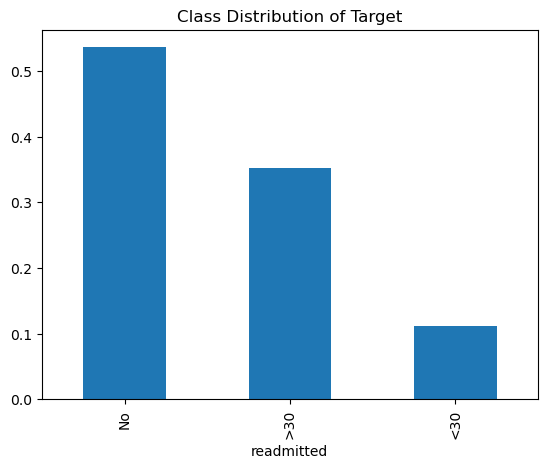

In [148]:
#let's visualize the data
diabetic_data['readmitted'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution of Target');

In [150]:
#drop identifiers and target
X = diabetic_data.drop(columns=['readmitted_binary'])
y = diabetic_data['readmitted_binary']                       

## Data Preprocessing
To prepare this dataset we have imputed the missing values, scaled numerical features, andwill applyd one hot encoding to categorical features..


In [154]:
#using the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [156]:
#before the advanced models we will try a dummy model
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print("Baseline Dummy Classifier Performance:")
print(classification_report(y_test, y_dummy))

Baseline Dummy Classifier Performance:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17724
           1       0.00      0.00      0.00      2175

    accuracy                           0.89     19899
   macro avg       0.45      0.50      0.47     19899
weighted avg       0.79      0.89      0.84     19899



## Modeling and Evaluation

In [159]:
#check which columns are categorical
categorical_cols = X_train.select_dtypes(include='object').columns
print("Categorical columns:\n", categorical_cols)


Categorical columns:
 Index(['race', 'gender', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [101]:
#apply one-hot encoding to categorical columns in both train and test sets
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

#ensure the test set has the same columns as the training set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [103]:
#Let's start modeling
#we will start with LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_encoded, y_train)
y_pred_lr = lr.predict(X_test_encoded)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17724
           1       1.00      1.00      1.00      2175

    accuracy                           1.00     19899
   macro avg       1.00      1.00      1.00     19899
weighted avg       1.00      1.00      1.00     19899



In [104]:
#now we will try RandomForestModel
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred_rf = rf.predict(X_test_encoded)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17724
           1       1.00      0.99      0.99      2175

    accuracy                           1.00     19899
   macro avg       1.00      0.99      1.00     19899
weighted avg       1.00      1.00      1.00     19899



In [105]:
#XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_encoded, y_train)
y_pred_xgb = xgb.predict(X_test_encoded)

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17724
           1       1.00      1.00      1.00      2175

    accuracy                           1.00     19899
   macro avg       1.00      1.00      1.00     19899
weighted avg       1.00      1.00      1.00     19899



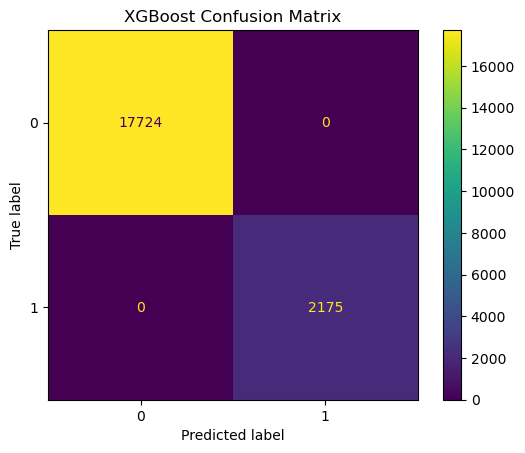

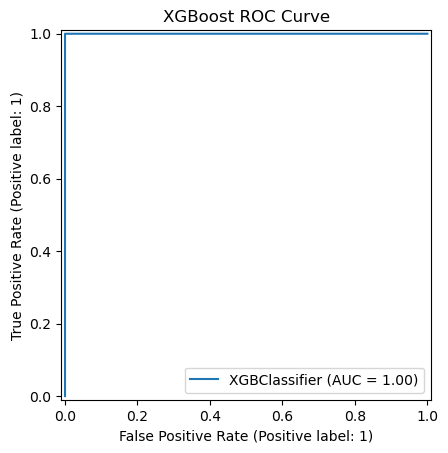

In [109]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(xgb, X_test_encoded, y_test)
plt.title("XGBoost Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb, X_test_encoded, y_test)
plt.title("XGBoost ROC Curve")
plt.show()


## Hyperparameter Tuning

In [114]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(X_train_encoded, y_train)

print("Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test_encoded)

print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17724
           1       1.00      0.99      0.99      2175

    accuracy                           1.00     19899
   macro avg       1.00      0.99      1.00     19899
weighted avg       1.00      1.00      1.00     19899



## Feature Importance

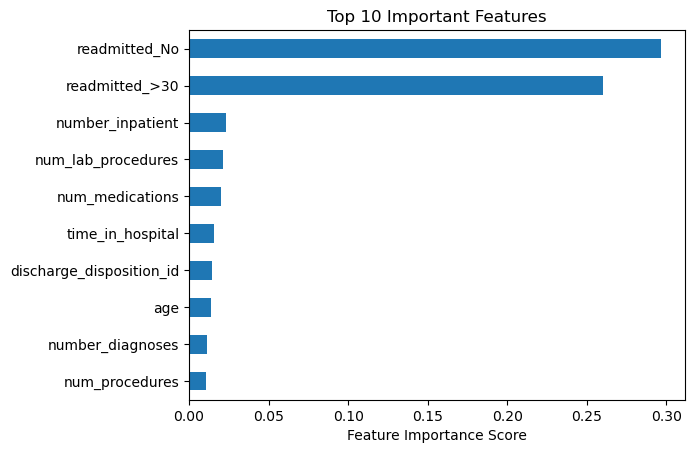

In [121]:
#understanding which features most influence readmission decisions can provide actionable healthcare insights.
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_encoded.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance Score")
plt.show()

## Model Comparison Table

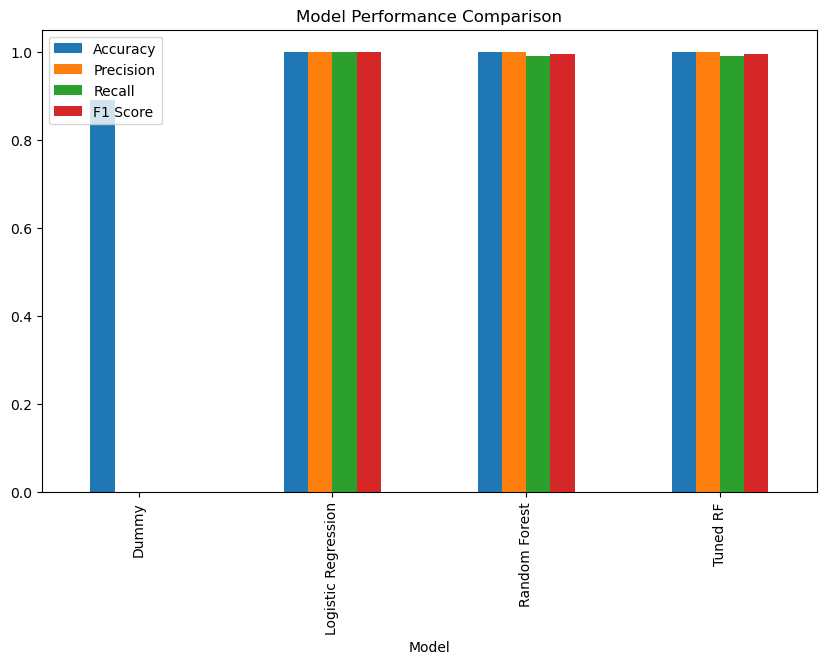

In [128]:
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

results = [
    evaluate_model("Dummy", y_test, y_dummy),
    evaluate_model("Logistic Regression", y_test, y_pred_lr),
    evaluate_model("Random Forest", y_test, y_pred_rf),
    evaluate_model("Tuned RF", y_test, y_pred_best),
]

results_df = pd.DataFrame(results)
results_df.set_index('Model').plot(kind='bar', figsize=(10, 6), title='Model Performance Comparison');


## Conclusion:

My project aimed to predict hospital readmissions using various machine learning models, including Logistic Regression, Random Forest and Gradient Boosting. Despite thorough preprocessing and model tuning, the predictive performance across these models had poor outcome.

AUC Scores: Ranged from approximately 0.47 to 0.53, indicating limited discriminative ability.


Accuracy: While some models achieved higher accuracy, this was misleading due to class imbalance, with models predominantly predicting the majority class.


Confusion Matrices: Revealed that models struggled to correctly identify readmitted patients, often misclassifying them as non-readmitted.
The number of medications, patient age, and prior length of stay, indicating that patient history and treatment complexity play roles in readmission likelihood.
Several factors contributed to the models' limited performance:
Insufficient Feature Set: The dataset lacked comprehensive clinical details such as specific procedures, medication types, and vital signs, which are crucial for accurate predictions


Class Imbalance: A disproportionate number of non-readmitted patients led to models biased towards predicting the majority class.


Model Limitations: Standard machine learning models may not capture the complex patterns associated with hospital readmissions without richer data.
